# Feature engineering

**Date:** July 24th, 2025  
**Author:** Paola Rocha  
**Description:** This Jupyter notebook contains the preprocessing and feature engineering steps used to prepare data for training a classification model. The objective is to predict whether a machine will fail within the next 30 days.

**Dataset:** [Microsoft Azure Predictive Maintenance](https://www.kaggle.com/datasets/arnabbiswas1/microsoft-azure-predictive-maintenance/data) on kaggle.

**Content:**  
* **Loading Data:** Importing the libraries and loading the datasets.  
* **Feature engineering:** Preprocessing the telemetry data and enriching it with information on errors, failures, and maintenance events. This section also includes the creation of the target variable indicating whether a machine is expected to fail in the near future.

## Loading data

In [1]:
import pandas as pd

In [2]:
errors = pd.read_csv('../data/raw/PdM_errors.csv', parse_dates=['datetime']).sort_values(['machineID', 'datetime'])
failures = pd.read_csv('../data/raw/PdM_failures.csv', parse_dates=['datetime']).sort_values(['machineID', 'datetime'])
machines = pd.read_csv('../data/raw/PdM_machines.csv')
maintenance = pd.read_csv('../data/raw/PdM_maint.csv', parse_dates=['datetime']).sort_values(['machineID', 'datetime'])
telemetry = pd.read_csv('../data/raw/PdM_telemetry.csv', parse_dates=['datetime']).sort_values(['machineID', 'datetime'])

## Feature engineering

### Telemetry dataset

We will aggregate the telemetry data on a daily basis to calculate the average values of the metrics (volt, rotate, pressure, and vibration). This step helps dealing with the datetime granularity with the other datasets.

In [3]:
def telemetry_grouping(telemetry_df):
    telemetry_df = telemetry_df.sort_values(['machineID', 'datetime'])
    telemetry_df['date'] = telemetry_df['datetime'].dt.normalize()
    telemetry_grouped = telemetry_df.groupby(by=['date', 'machineID']) \
        .agg({'volt': 'mean', 'rotate': 'mean', 'pressure': 'mean', 'vibration': 'mean'}).reset_index()
    return telemetry_grouped

In [4]:
telemetry_grouped = telemetry_grouping(telemetry)
telemetry_grouped

,date,machineID,volt,rotate,pressure,vibration
0,2015-01-01,1,167.576533,440.515328,98.522345,40.049623
1,2015-01-01,2,173.738811,445.200094,100.728570,41.439609
2,2015-01-01,3,168.923402,454.152365,100.362017,36.289645
3,2015-01-01,4,168.459275,447.758764,98.139800,41.573753
4,2015-01-01,5,173.108601,450.183235,97.544686,39.287064
...,...,...,...,...,...,...
36595,2016-01-01,96,163.701974,458.058551,98.829202,38.005677
36596,2016-01-01,97,175.247124,449.519362,100.197656,40.741088
36597,2016-01-01,98,174.122791,461.853080,120.535268,42.283684
36598,2016-01-01,99,169.200437,450.518923,99.581414,42.219457


### Adding features

Using the errors, failures, and maintenance datasets, we can enrich the telemetry data by adding features that count the number of errors, failed components, and maintenance events within sliding windows of 7, 14, and 30 days

In [ ]:
def add_features(df: pd.DataFrame, type_name: str, window_sizes: list = [7, 14, 30]):
    df = df.sort_values(['machineID', 'datetime'])
    df['date'] = df['datetime'].dt.normalize()

    for idx, row in telemetry_grouped.iterrows():
        current_date = row['date']
        machine = row['machineID']

        # Filter rows for the same machine in a window
        for window in window_sizes:
            # Create a mask for the last 'window' days
            mask = (
                (df['machineID'] == machine) &
                (df['date'] >= current_date - pd.Timedelta(days=window)) &
                (df['date'] <= current_date)
            )

            # Count how many errors, failures or maintenance occurred in that window
            telemetry_grouped.at[idx, f'{type_name}_last_{window}_days'] = mask.sum()

def add_target_feature(df: pd.DataFrame, window_size: int = 30):
    df = df.sort_values(['machineID', 'datetime'])
    df['date'] = df['datetime'].dt.normalize()

    for idx, row in telemetry_grouped.iterrows():
        current_date = row['date']
        machine = row['machineID']

        mask = (
            (df['machineID'] == machine) &
            (df['date'] <= current_date + pd.Timedelta(days=window_size)) &
            (df['date'] >= current_date)
        )

        # See if there are any failures in the next 'window_size' days
        will_fail = 1 if mask.sum() > 0 else 0
        telemetry_grouped.at[idx, f'will_fail_{window_size}_days'] = will_fail

In [6]:
# Adding features for errors, failures, and maintenance
add_features(errors, 'error')
add_features(failures, 'failure')
add_features(maintenance, 'maint')

To define the target variable, we will create a column named `will_fail_30_days`, which indicates whether a machine is expected to fail within the next 30 days

In [7]:
# Adding target feature for future failures
add_target_feature(failures)

As shown in the plot below, the dataset is balanced, so there is no need to apply techniques for handling class imbalance, such as SMOTE

<Axes: xlabel='will_fail_30_days'>

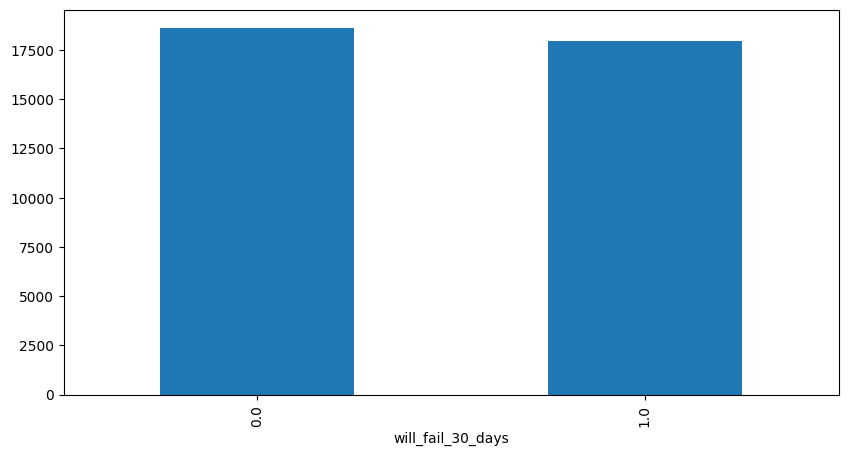

In [8]:
telemetry_grouped.will_fail_30_days.value_counts().plot(kind='bar', figsize=(10, 5))

Next, we can enrich the telemetry dataset by adding information about each machine’s age and model

In [9]:
# Merging telemetry with the machines data
final_df = telemetry_grouped.merge(machines, on='machineID', how='left')
final_df['model'] = final_df['model'].replace({'model1': 0, 'model2': 1, 'model3': 2, 'model4': 3})
final_df

/var/folders/ny/p8x9__2s12j7zfch0kt9qqth0000gn/T/ipykernel_72142/1284145655.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_df['model'] = final_df['model'].replace({'model1': 0, 'model2': 1, 'model3': 2, 'model4': 3})


,date,machineID,volt,rotate,pressure,vibration,error_last_7_days,error_last_14_days,error_last_30_days,failure_last_7_days,failure_last_14_days,failure_last_30_days,maint_last_7_days,maint_last_14_days,maint_last_30_days,will_fail_30_days,model,age
0,2015-01-01,1,167.576533,440.515328,98.522345,40.049623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2,18
1,2015-01-01,2,173.738811,445.200094,100.728570,41.439609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,7
2,2015-01-01,3,168.923402,454.152365,100.362017,36.289645,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,8
3,2015-01-01,4,168.459275,447.758764,98.139800,41.573753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2,7
4,2015-01-01,5,173.108601,450.183235,97.544686,39.287064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36595,2016-01-01,96,163.701974,458.058551,98.829202,38.005677,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,0.0,1,10
36596,2016-01-01,97,175.247124,449.519362,100.197656,40.741088,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,1,14
36597,2016-01-01,98,174.122791,461.853080,120.535268,42.283684,1.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,1,20
36598,2016-01-01,99,169.200437,450.518923,99.581414,42.219457,0.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0,14


In [10]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36600 entries, 0 to 36599
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  36600 non-null  datetime64[ns]
 1   machineID             36600 non-null  int64         
 2   volt                  36600 non-null  float64       
 3   rotate                36600 non-null  float64       
 4   pressure              36600 non-null  float64       
 5   vibration             36600 non-null  float64       
 6   error_last_7_days     36600 non-null  float64       
 7   error_last_14_days    36600 non-null  float64       
 8   error_last_30_days    36600 non-null  float64       
 9   failure_last_7_days   36600 non-null  float64       
 10  failure_last_14_days  36600 non-null  float64       
 11  failure_last_30_days  36600 non-null  float64       
 12  maint_last_7_days     36600 non-null  float64       
 13  maint_last_14_da

In [ ]:
# Saving the final DataFrame to a CSV file
final_df.to_csv('../data/processed/telemetry.csv', index=False)